In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Positive signals - clicks, details, ratings, purchases

DataFrame consists of interactions between users and items

In [2]:
prefix = Path("../../data/contentwise/data/contentwise/CW10M/")
interactions_path = prefix / Path("interactions")
interactions = pd.concat(
    pd.read_parquet(p) for p in interactions_path.glob("*.parquet")
).reset_index()

interactions["utc_ts_milliseconds"] = pd.to_datetime(
    interactions["utc_ts_milliseconds"], unit="ms"
)
interactions["date"] = interactions["utc_ts_milliseconds"].dt.date
interactions = interactions.sort_values("utc_ts_milliseconds").reset_index(drop=True)

interactions["item_type"] = interactions["item_type"].map(
    {
        0: "movies",
        1: "movies and clips in series",
        2: "TV movies or shows",
        3: "episodes of TV series",
    }
)
interactions["interaction_type"] = interactions["interaction_type"].map(
    {0: "views", 1: "details", 2: "ratings", 3: "purchases"}
)

interactions

,utc_ts_milliseconds,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,date
0,2019-01-07 09:00:02,27944,23602,8872,9,17,episodes of TV series,-1,views,1.00,-1.0,2019-01-07
1,2019-01-07 09:00:02,7285,116485,434,5,6,episodes of TV series,56402,views,1.00,-1.0,2019-01-07
2,2019-01-07 09:00:03,26039,52201,4323,69,365,episodes of TV series,-1,details,-1.00,-1.0,2019-01-07
3,2019-01-07 09:00:03,9752,55164,3544,17,21,episodes of TV series,-1,views,1.00,-1.0,2019-01-07
4,2019-01-07 09:00:04,41020,115035,4549,21,21,episodes of TV series,-1,details,-1.00,-1.0,2019-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...
10457805,2019-04-15 08:59:54,9517,5918,3134,10,11,episodes of TV series,-1,details,-1.00,-1.0,2019-04-15
10457806,2019-04-15 08:59:56,34898,114098,23089,3,11,episodes of TV series,-1,views,1.00,-1.0,2019-04-15
10457807,2019-04-15 08:59:57,3388,8059,8277,4,27,episodes of TV series,-1,views,1.00,-1.0,2019-04-15
10457808,2019-04-15 08:59:58,2536,9462,23781,9,12,episodes of TV series,-1,views,1.00,-1.0,2019-04-15


Mapping of item_type:
- 0 - movies
- 1 - movies and clips in series
- 2 - TV movies or shows
- 3 - episodes of TV series

Mapping of interaction_type:
- 0 - views
- 1 - details
- 2 - ratings
- 3 - purchases

In [3]:
interactions["item_type"].value_counts()

item_type
episodes of TV series         9076428
movies                         987518
movies and clips in series     231290
TV movies or shows             162574
Name: count, dtype: int64

## Keep movies only!

In [5]:
interactions = interactions[interactions["item_type"] == "movies"].reset_index(
    drop=True
)
interactions.shape

(987518, 12)

In [6]:
interactions.head()

,utc_ts_milliseconds,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,date
0,2019-01-07 09:00:04,17094,86576,16187,1,1,movies,272495,details,-1.0,-1.0,2019-01-07
1,2019-01-07 09:00:07,9011,9614,23832,1,1,movies,-1,details,-1.0,-1.0,2019-01-07
2,2019-01-07 09:00:22,17094,13926,27394,1,1,movies,8022,details,-1.0,-1.0,2019-01-07
3,2019-01-07 09:00:26,10478,37741,27655,1,1,movies,-1,details,-1.0,-1.0,2019-01-07
4,2019-01-07 09:00:48,17094,86576,16187,1,1,movies,272495,details,-1.0,-1.0,2019-01-07


## Duplicates

In [7]:
interactions.drop_duplicates().shape

(987461, 12)

In [8]:
interactions[["user_id", "series_id", "interaction_type"]].drop_duplicates().shape

(697360, 3)

In [9]:
interactions[
    ["user_id", "series_id", "interaction_type", "date"]
].drop_duplicates().shape

(838994, 4)

## Features

### interaction_type

In [10]:
tmp = interactions["interaction_type"].value_counts()
tmp

interaction_type
views        519179
details      389614
purchases     71324
ratings        7401
Name: count, dtype: int64

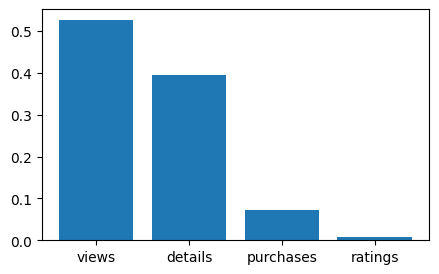

In [11]:
plt.figure(figsize=(5, 3))

plt.bar(tmp.index, tmp / interactions.shape[0])

plt.show()

Number of users and items per interaction type:

In [12]:
tmp = interactions.groupby("interaction_type").agg(
    {"user_id": "nunique", "series_id": "nunique"}
)
tmp.columns = ["n_users", "n_items"]
tmp["n_users (%)"] = 100 * tmp["n_users"] / interactions["user_id"].nunique()
tmp["n_items (%)"] = 100 * tmp["n_items"] / interactions["series_id"].nunique()
tmp

,n_users,n_items,n_users (%),n_items (%)
interaction_type,,,,
details,16637,11351,48.129719,90.691914
purchases,21469,5021,62.108369,40.116651
ratings,3534,1726,10.223624,13.790348
views,32063,10003,92.756097,79.921700


In [13]:
interactions[interactions["recommendation_id"] != -1]["interaction_type"].value_counts()

interaction_type
details    62888
views      51928
Name: count, dtype: int64

Some 'views' (around 10%) and 'details' (around 16%) actions come from recommendation slates (via recommendation_id != -1) 

In [14]:
interactions[interactions["vision_factor"] != -1]["interaction_type"].value_counts()

interaction_type
views    519179
Name: count, dtype: int64

All 'views' actions have corresponding vision factor value 

In [15]:
interactions[interactions["explicit_rating"] != -1]["interaction_type"].value_counts()

interaction_type
ratings    7401
Name: count, dtype: int64

All 'ratings' actions have corresponding explicit rating value

### user_id

In [16]:
print(f"# Users: {interactions['user_id'].nunique()}")

# Users: 34567


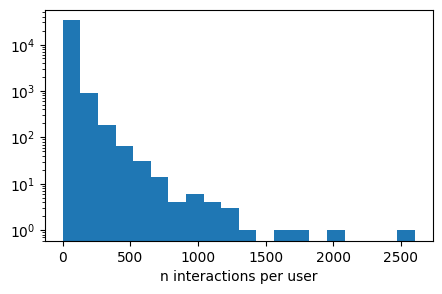

In [17]:
plt.figure(figsize=(5, 3))

plt.hist(interactions["user_id"].value_counts(), bins=20)
plt.yscale("log")
plt.xlabel("n interactions per user")

plt.show()

Users' activity per interaction_type:

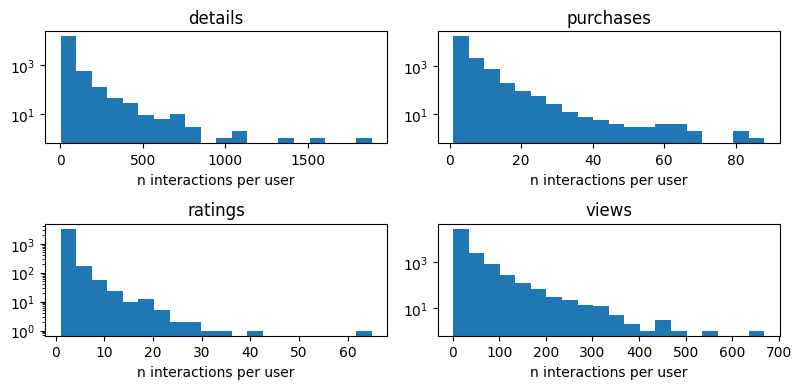

In [18]:
tmp = interactions.groupby(["interaction_type", "user_id"]).size().reset_index()


# Plot
fig, axs = plt.subplots(2, 2, figsize=(8, 4))

for i, interaction_type in enumerate(tmp["interaction_type"].unique()):
    axs[i // 2, i % 2].set_title(interaction_type)
    axs[i // 2, i % 2].hist(
        tmp.loc[tmp["interaction_type"] == interaction_type, 0], bins=20
    )
    axs[i // 2, i % 2].set_yscale("log")
    axs[i // 2, i % 2].set_xlabel("n interactions per user")

plt.tight_layout()
plt.show()

Most active users (top10):

In [19]:
tmp1 = interactions["user_id"].value_counts()[:10].reset_index()
tmp1.columns = pd.MultiIndex.from_product([["total"], tmp1.columns])

tmp2 = (
    interactions.loc[interactions["interaction_type"] == "views", "user_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp2.columns = pd.MultiIndex.from_product([["views"], tmp2.columns])

tmp3 = (
    interactions.loc[interactions["interaction_type"] == "details", "user_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp3.columns = pd.MultiIndex.from_product([["details"], tmp3.columns])

tmp4 = (
    interactions.loc[interactions["interaction_type"] == "ratings", "user_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp4.columns = pd.MultiIndex.from_product([["ratings"], tmp4.columns])

tmp5 = (
    interactions.loc[interactions["interaction_type"] == "purchases", "user_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp5.columns = pd.MultiIndex.from_product([["purchases"], tmp5.columns])

tmp = pd.concat((tmp1, tmp2, tmp3, tmp4, tmp5), axis=1)
tmp.index = [f"top{i}" for i in range(1, 11)]
tmp

total         views       details       ratings       purchases      
      user_id count user_id count user_id count user_id count   user_id count
top1    38381  2604   38381   669   38381  1887   22887    65     36504    88
top2     4213  1983   35241   558    4213  1580   38381    42     24667    81
top3    38948  1722   22471   470   38948  1361   19291    35     22887    81
top4    35241  1658   10252   453   35241  1088   39549    30     19277    70
top5    30387  1357   40672   450   30387  1077   14839    29      9766    69
top6    22730  1294    8991   447   22730  1023   20368    27      6200    66
top7    40672  1290     559   405   40672   827    6630    26     21064    66
top8    22887  1175   36564   390    3024   816    7604    25      5348    64
top9     8991  1170    4213   387   10496   811   38582    23       499    62
top10    9571  1090    9571   368    8399   745   40527    23      8890    59

### series_id

In [22]:
print(f"# Items: {interactions['series_id'].nunique()}")

# Items: 12516


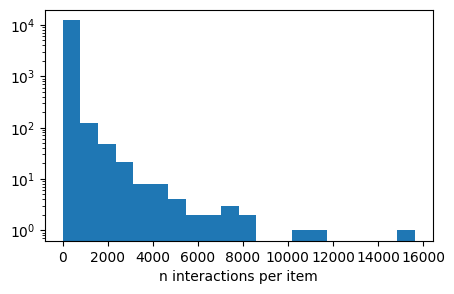

In [23]:
plt.figure(figsize=(5, 3))

plt.hist(interactions["series_id"].value_counts(), bins=20)
plt.yscale("log")
plt.xlabel("n interactions per item")

plt.show()

Items' activity per interaction_type:

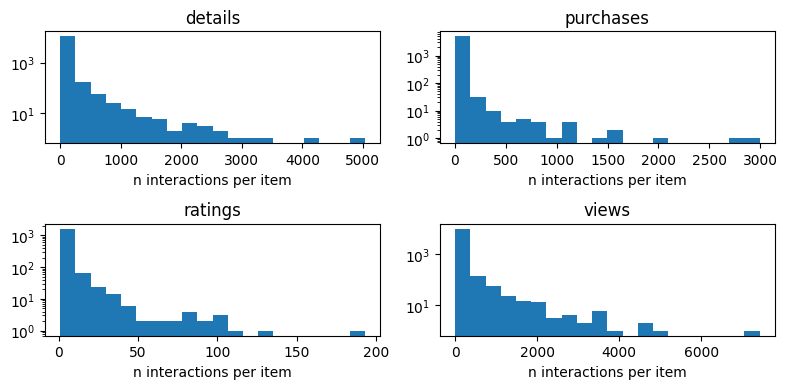

In [24]:
tmp = interactions.groupby(["interaction_type", "series_id"]).size().reset_index()


# Plot
fig, axs = plt.subplots(2, 2, figsize=(8, 4))

for i, interaction_type in enumerate(tmp["interaction_type"].unique()):
    axs[i // 2, i % 2].set_title(interaction_type)
    axs[i // 2, i % 2].hist(
        tmp.loc[tmp["interaction_type"] == interaction_type, 0], bins=20
    )
    axs[i // 2, i % 2].set_yscale("log")
    axs[i // 2, i % 2].set_xlabel("n interactions per item")

plt.tight_layout()
plt.show()

Most active items (top10):

In [25]:
tmp1 = interactions["series_id"].value_counts()[:10].reset_index()
tmp1.columns = pd.MultiIndex.from_product([["total"], tmp1.columns])

tmp2 = (
    interactions.loc[interactions["interaction_type"] == "views", "series_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp2.columns = pd.MultiIndex.from_product([["views"], tmp2.columns])

tmp3 = (
    interactions.loc[interactions["interaction_type"] == "details", "series_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp3.columns = pd.MultiIndex.from_product([["details"], tmp3.columns])

tmp4 = (
    interactions.loc[interactions["interaction_type"] == "ratings", "series_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp4.columns = pd.MultiIndex.from_product([["ratings"], tmp4.columns])

tmp5 = (
    interactions.loc[interactions["interaction_type"] == "purchases", "series_id"]
    .value_counts()[:10]
    .reset_index()
)
tmp5.columns = pd.MultiIndex.from_product([["purchases"], tmp5.columns])

tmp = pd.concat((tmp1, tmp2, tmp3, tmp4, tmp5), axis=1)
tmp.index = [f"top{i}" for i in range(1, 11)]
tmp

total            views         details         ratings        \
      series_id  count series_id count series_id count series_id count   
top1      15641  15644     15641  7423     15641  5032     15641   193   
top2       9026  11570      5101  5107      9026  4122      9026   135   
top3       5101  10795     20721  4682      5101  3511      5101   114   
top4        466   8022      9026  4508     20721  3092     18398   102   
top5      20721   7863     23451  3871     16966  2862     16966    98   
top6      16966   7772     16966  3679       466  2681       325    97   
top7      22607   7191       466  3679     22607  2560     18972    96   
top8      18398   7185       325  3655     17345  2462     23451    92   
top9      23451   6730     18398  3574     18398  2440     23080    87   
top10     23080   6573     19911  3454     23080  2333      1842    87   

      purchases        
      series_id count  
top1      15641  2996  
top2       9026  2805  
top3       5101  2063  
top4        466  1609  
top5      22607  1582  
top6      18972  1453  
top7      16966  1133  
top8      18398  1069  
top9      10729  1060  
top10     11180  1050

### vision_factor

Check whether all rows indicating clicked item are fullfiled with vision_factor

In [26]:
(interactions["interaction_type"] == "views").sum() == (
    interactions["vision_factor"] != -1
).sum()

True

In [27]:
interactions["vision_factor"].value_counts()

vision_factor
-1.00    468339
 1.00    137971
 0.97     35156
 0.98     30238
 0.96     24559
          ...  
 0.79      1532
 0.75      1516
 0.74      1513
 0.85      1501
 0.77      1491
Name: count, Length: 101, dtype: int64

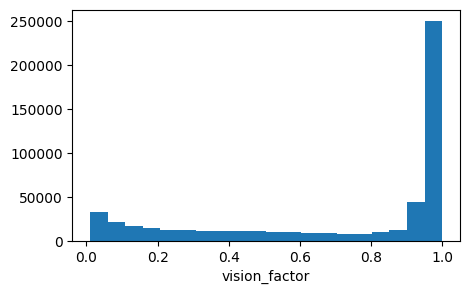

In [28]:
plt.figure(figsize=(5, 3))

plt.hist(
    interactions.loc[interactions["vision_factor"] != -1, "vision_factor"], bins=20
)
plt.xlabel("vision_factor")

plt.show()

### explicit_rating

Check if all rows indicating rated item are really fullfiled explicit_rating

In [29]:
(interactions["interaction_type"] == "ratings").sum() == (
    interactions["explicit_rating"] != -1
).sum()

True

In [30]:
tmp = interactions["explicit_rating"].value_counts().sort_index()
tmp

explicit_rating
-1.0    980117
 0.5       192
 1.0       105
 1.5        59
 2.0       145
 2.5       120
 3.0      2938
 3.5       478
 4.0      1038
 4.5       518
 5.0      1808
Name: count, dtype: int64

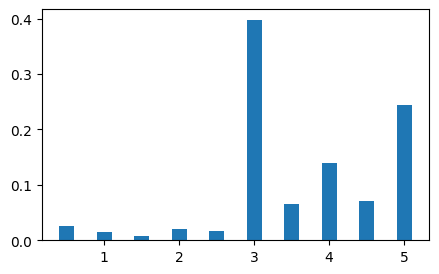

In [31]:
plt.figure(figsize=(5, 3))

plt.bar(
    list(tmp.index[1:]),
    tmp.iloc[1:] / (interactions["explicit_rating"] != -1).sum(),
    width=0.2,
)

plt.show()

## Stats per day

### Basic statistics

In [32]:
# Compute new users and items in each day (new user/item means user/item that didn't appear in the past)

users_per_day = interactions.groupby("date")["user_id"].unique()
items_per_day = interactions.groupby("date")["series_id"].unique()

all_prev_users = users_per_day[0]
n_new_users = [all_prev_users.size]
all_prev_items = items_per_day[0]
n_new_items = [all_prev_items.size]

for users in users_per_day[1:]:
    new_users = np.setdiff1d(users, all_prev_users)
    n_new_users.append(new_users.size)
    all_prev_users = np.union1d(all_prev_users, users)

for items in items_per_day[1:]:
    new_items = np.setdiff1d(items, all_prev_items)
    n_new_items.append(new_items.size)
    all_prev_items = np.union1d(all_prev_items, items)

/tmp/ipykernel_37004/1842013794.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_prev_users = users_per_day[0]
/tmp/ipykernel_37004/1842013794.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_prev_items = items_per_day[0]


In [33]:
# Stats per day

views_per_day = (
    interactions[interactions["interaction_type"] == "views"].groupby("date").size()
)
details_per_day = (
    interactions[interactions["interaction_type"] == "details"].groupby("date").size()
)
ratings_per_day = (
    interactions[interactions["interaction_type"] == "ratings"].groupby("date").size()
)
purchases_per_day = (
    interactions[interactions["interaction_type"] == "purchases"].groupby("date").size()
)

stats_per_day = interactions.groupby("date").agg(
    {"user_id": "nunique", "series_id": "nunique", "utc_ts_milliseconds": "count"},
)
stats_per_day.columns = ["n_users", "n_items", "n_actions"]

stats_per_day["n_views"] = views_per_day
stats_per_day["n_details"] = details_per_day
stats_per_day["n_ratings"] = ratings_per_day
stats_per_day["n_purchases"] = purchases_per_day

stats_per_day["n_new_users"] = n_new_users
stats_per_day["n_new_items"] = n_new_items

stats_per_day

,n_users,n_items,n_actions,n_views,n_details,n_ratings,n_purchases,n_new_users,n_new_items
date,,,,,,,,,
2019-01-07,2108,1514,6591,3225,2918,48,400,2108,1514
2019-01-08,2479,1552,7352,3770,3061,68,453,1722,746
2019-01-09,2546,1549,7226,3799,2954,52,421,1382,546
2019-01-10,2402,1572,7210,3721,3039,64,386,1061,483
2019-01-11,2855,1613,8373,4367,3397,68,541,1231,418
...,...,...,...,...,...,...,...,...,...
2019-04-11,2489,1606,7504,4173,2872,54,405,40,35
2019-04-12,2813,1733,8448,4571,3307,52,518,66,33
2019-04-13,4005,2283,13089,6896,5185,77,931,98,47


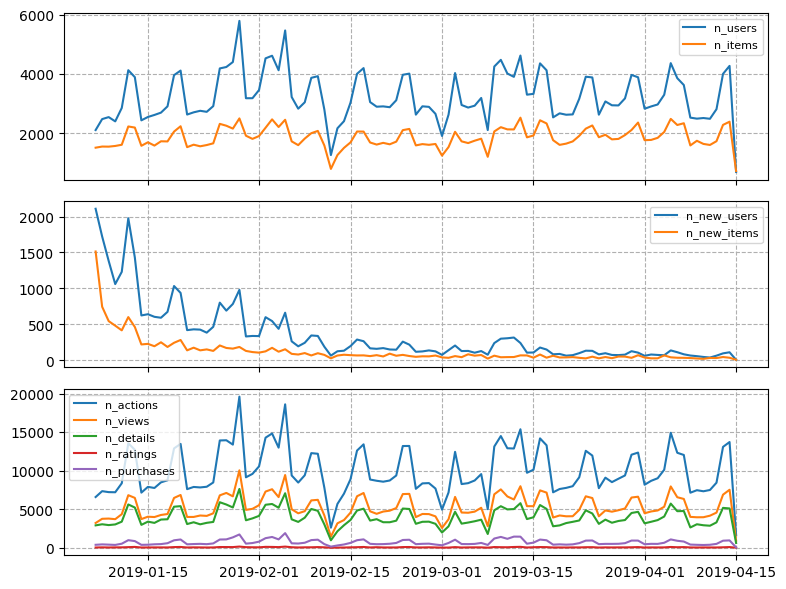

In [34]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axs[0].plot(stats_per_day[["n_users", "n_items"]])
axs[0].legend(["n_users", "n_items"], fontsize=8)
axs[0].grid(linestyle="--")

axs[1].plot(stats_per_day[["n_new_users", "n_new_items"]])
axs[1].legend(["n_new_users", "n_new_items"], fontsize=8)
axs[1].grid(linestyle="--")

axs[2].plot(
    stats_per_day[["n_actions", "n_views", "n_details", "n_ratings", "n_purchases"]]
)
axs[2].legend(
    ["n_actions", "n_views", "n_details", "n_ratings", "n_purchases"], fontsize=8
)
axs[2].grid(linestyle="--")

plt.tight_layout()
plt.show()

### 10 most and least active users per day (all interactions)

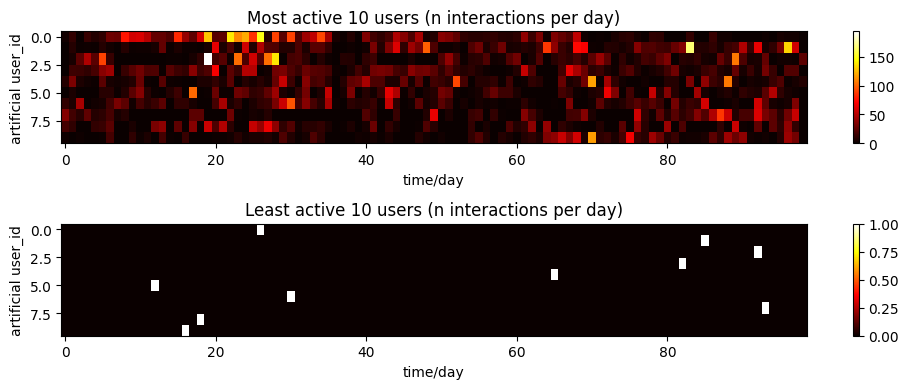

In [35]:
tmp = interactions.pivot_table("series_id", "user_id", "date", aggfunc="count").fillna(
    0
)

most_active_10_users = tmp.sum(axis=1).sort_values(ascending=False).index[:10]
tmp1 = tmp.loc[most_active_10_users, :].to_numpy()
least_active_10_users = tmp.sum(axis=1).sort_values(ascending=True).index[:10]
tmp2 = tmp.loc[least_active_10_users, :].to_numpy()

fig, axs = plt.subplots(2, 1, figsize=(10, 4))

axs[0].set_title("Most active 10 users (n interactions per day)")
c = axs[0].imshow(tmp1, cmap="hot", aspect="auto")
plt.colorbar(c, ax=axs[0])
axs[0].set_xlabel("time/day")
axs[0].set_ylabel("artificial user_id")

axs[1].set_title("Least active 10 users (n interactions per day)")
c = axs[1].imshow(tmp2, cmap="hot", aspect="auto")
plt.colorbar(c, ax=axs[1])
axs[1].set_xlabel("time/day")
axs[1].set_ylabel("artificial user_id")

plt.tight_layout()
plt.show()

### 10 most and least active items per day (all interactions)

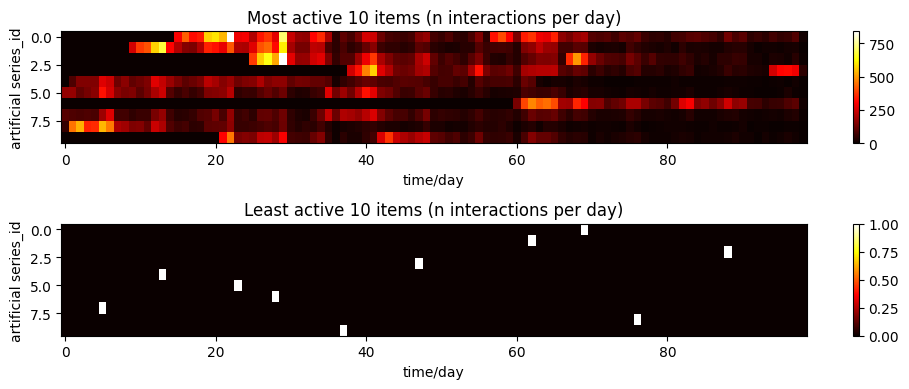

In [36]:
tmp = interactions.pivot_table("user_id", "series_id", "date", aggfunc="count").fillna(
    0
)

most_active_10_items = tmp.sum(axis=1).sort_values(ascending=False).index[:10]
tmp1 = tmp.loc[most_active_10_items, :].to_numpy()
least_active_10_items = tmp.sum(axis=1).sort_values(ascending=True).index[:10]
tmp2 = tmp.loc[least_active_10_items, :].to_numpy()

fig, axs = plt.subplots(2, 1, figsize=(10, 4))

axs[0].set_title("Most active 10 items (n interactions per day)")
c = axs[0].imshow(tmp1, cmap="hot", aspect="auto")
plt.colorbar(c, ax=axs[0])
axs[0].set_xlabel("time/day")
axs[0].set_ylabel("artificial series_id")

axs[1].set_title("Least active 10 items (n interactions per day)")
c = axs[1].imshow(tmp2, cmap="hot", aspect="auto")
plt.colorbar(c, ax=axs[1])
axs[1].set_xlabel("time/day")
axs[1].set_ylabel("artificial series_id")

plt.tight_layout()
plt.show()

# Negative signals - impressions (direct)

In [37]:
impressions_dl_path = prefix / Path("impressions-direct-link")
impressions_dl = pd.concat(
    pd.read_parquet(p) for p in impressions_dl_path.glob("*.parquet")
).reset_index()
impressions_dl

,recommendation_id,row_position,recommendation_list_length,recommended_series_list
0,0,0,10,"[20128, 6674, 4625, 19462, 19041, 23229, 5914,..."
1,1,0,10,"[7906, 1240, 1712, 8348, 3227, 7607, 24175, 15..."
2,2,0,10,"[13673, 15810, 16821, 3826, 26860, 22223, 1847..."
3,3,1,10,"[13673, 1272, 2293, 23996, 15810, 16821, 13737..."
4,4,0,6,"[21885, 22288, 7493, 17042, 18483, 9330]"
...,...,...,...,...
307448,307449,0,12,"[21261, 26515, 5544, 1393, 5678, 22552, 9101, ..."
307449,307450,1,10,"[20128, 4862, 6674, 28598, 27215, 4625, 19041,..."
307450,307451,0,30,"[9969, 17425, 9101, 14797, 5743, 4172, 17953, ..."
307451,307452,0,10,"[21079, 23099, 28598, 25404, 19462, 26304, 152..."


## Features

### row_position

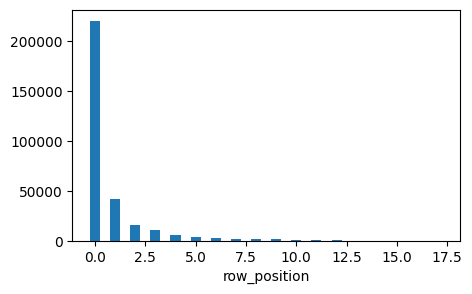

In [38]:
tmp = impressions_dl["row_position"].value_counts().sort_index()

plt.figure(figsize=(5, 3))

plt.bar(list(tmp.index), tmp, width=0.5)
plt.xlabel("row_position")

plt.show()

### recommendation_list_length

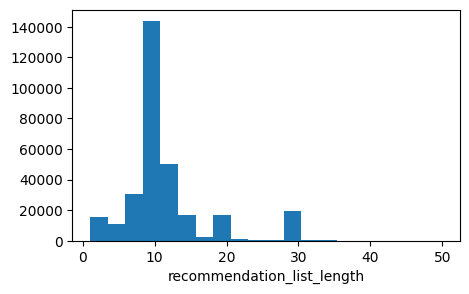

In [39]:
plt.figure(figsize=(5, 3))

plt.hist(impressions_dl["recommendation_list_length"], bins=20)
plt.xlabel("recommendation_list_length")

plt.show()

# Merged positive and negative interactions

In [56]:
merged = interactions.merge(impressions_dl, "left", "recommendation_id")

merged = merged.explode("recommended_series_list").reset_index(drop=True)
merged["recommended_series_list"] = pd.to_numeric(merged["recommended_series_list"])

In [57]:
merged["signal"] = 0  # Set negative signals as 0 (init column with zeros)
merged.loc[
    merged["recommendation_id"] == -1, "signal"
] = 1  # Set positive signals as 1 (all interactions which don't come from recommendation slates)
merged.loc[
    merged["series_id"] == merged["recommended_series_list"], "signal"
] = 1  # Set positive signals as 1 ('views' action)

merged.loc[~merged["recommended_series_list"].isna(), "series_id"] = merged.loc[
    ~merged["recommended_series_list"].isna(), "recommended_series_list"
]

merged.loc[merged["signal"] == 0, "interaction_type"] = "impressions"
merged.loc[merged["interaction_type"] == "impressions", "vision_factor"] = -1
merged.loc[
    (merged["interaction_type"] == "ratings") & (merged["explicit_rating"] < 3),
    "signal",
] = 0  # Set low ratings as negative signal

merged = merged.drop(
    columns=[
        "item_id",
        "episode_number",
        "series_length",
        "item_type",
        "date",
        "row_position",
        "recommendation_list_length",
        "recommended_series_list",
    ]
)

merged

,utc_ts_milliseconds,user_id,series_id,recommendation_id,interaction_type,vision_factor,explicit_rating,signal
0,2019-01-07 09:00:04,17094,6854,272495,impressions,-1.00,-1.0,0
1,2019-01-07 09:00:04,17094,19911,272495,impressions,-1.00,-1.0,0
2,2019-01-07 09:00:04,17094,10228,272495,impressions,-1.00,-1.0,0
3,2019-01-07 09:00:04,17094,1483,272495,impressions,-1.00,-1.0,0
4,2019-01-07 09:00:04,17094,16806,272495,impressions,-1.00,-1.0,0
...,...,...,...,...,...,...,...,...
2706309,2019-04-15 08:56:53,29764,1770,-1,views,1.00,-1.0,1
2706310,2019-04-15 08:57:25,39325,23882,-1,views,0.02,-1.0,1
2706311,2019-04-15 08:58:58,5610,26746,-1,purchases,-1.00,-1.0,1
2706312,2019-04-15 08:59:51,26024,14716,-1,details,-1.00,-1.0,1


## Prepare weights of each interaction

In [58]:
merged["interaction_weight"] = 0.5
# Weights based on vision_factor
merged.loc[merged["vision_factor"] != -1, "interaction_weight"] = merged[
    "vision_factor"
]
# Weights based on explicit_rating
merged.loc[merged["explicit_rating"] != -1, "interaction_weight"] = 1
# Weights based on time (square root of normalized (0-1) value)
merged["days_ago"] = (
    merged["utc_ts_milliseconds"].max() - merged["utc_ts_milliseconds"]
).dt.days
merged["time_weight"] = np.sqrt(
    (merged["days_ago"].max() - merged["days_ago"]) / merged["days_ago"].max()
)

# Final signal weights
merged["final_signal_weight"] = (
    merged["interaction_weight"] + merged["time_weight"]
) / 2
merged

,utc_ts_milliseconds,user_id,series_id,recommendation_id,interaction_type,vision_factor,explicit_rating,signal,interaction_weight,days_ago,time_weight,final_signal_weight
0,2019-01-07 09:00:04,17094,6854,272495,impressions,-1.00,-1.0,0,0.50,97,0.0,0.25
1,2019-01-07 09:00:04,17094,19911,272495,impressions,-1.00,-1.0,0,0.50,97,0.0,0.25
2,2019-01-07 09:00:04,17094,10228,272495,impressions,-1.00,-1.0,0,0.50,97,0.0,0.25
3,2019-01-07 09:00:04,17094,1483,272495,impressions,-1.00,-1.0,0,0.50,97,0.0,0.25
4,2019-01-07 09:00:04,17094,16806,272495,impressions,-1.00,-1.0,0,0.50,97,0.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
2706309,2019-04-15 08:56:53,29764,1770,-1,views,1.00,-1.0,1,1.00,0,1.0,1.00
2706310,2019-04-15 08:57:25,39325,23882,-1,views,0.02,-1.0,1,0.02,0,1.0,0.51
2706311,2019-04-15 08:58:58,5610,26746,-1,purchases,-1.00,-1.0,1,0.50,0,1.0,0.75
2706312,2019-04-15 08:59:51,26024,14716,-1,details,-1.00,-1.0,1,0.50,0,1.0,0.75


## Statistics

In [59]:
print(f"# Users: {merged['user_id'].nunique()}")
print(f"# Items: {merged['series_id'].nunique()}")

# Users: 34567
# Items: 13720


In [60]:
merged.shape

(2706314, 12)

Distribution of interaction_type

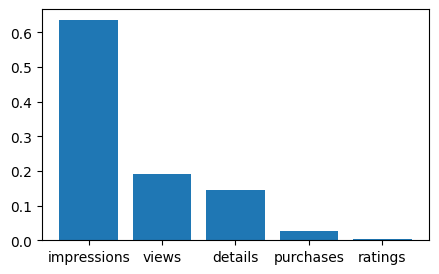

In [61]:
tmp = merged["interaction_type"].value_counts()

plt.figure(figsize=(5, 3))
plt.bar(tmp.index, tmp / tmp.sum())
plt.show()

Distribution of final_signal_weight

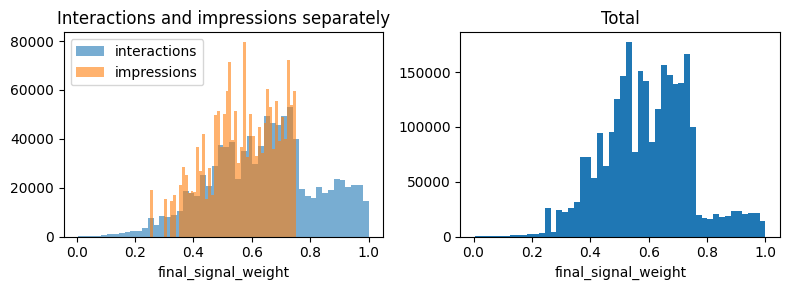

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].set_title("Interactions and impressions separately")
axs[0].hist(
    merged.loc[merged["interaction_type"] != "impressions", "final_signal_weight"],
    bins=50,
    alpha=0.6,
    label="interactions",
)
axs[0].hist(
    merged.loc[merged["interaction_type"] == "impressions", "final_signal_weight"],
    bins=50,
    alpha=0.6,
    label="impressions",
)
axs[0].legend()
axs[0].set_xlabel("final_signal_weight")

axs[1].set_title("Total")
axs[1].hist(merged["final_signal_weight"], bins=50)
axs[1].set_xlabel("final_signal_weight")

plt.tight_layout()
plt.show()

## Most popular items

### Based on vision_factor

#### mean

Computed on items [partly or fully] watched at least 30 times. Sorted by weighted_mean_vision_factor.

In [63]:
tmp = merged[(merged["vision_factor"] != -1) & (merged["time_weight"] != 0)]
wm = lambda x: np.average(x, weights=merged.loc[x.index, "time_weight"])

tmp = (
    tmp.groupby("series_id")
    .agg(
        count=("vision_factor", "count"),
        mean_vision_factor=("vision_factor", "mean"),
        weighted_mean_vision_factor=("vision_factor", wm),
    )
    .sort_values("weighted_mean_vision_factor", ascending=False)
)
tmp[tmp["count"] >= 30][:10]

,count,mean_vision_factor,weighted_mean_vision_factor
series_id,,,
23237,103,0.990097,0.991357
9047,2073,0.985620,0.987026
11846,37,0.990000,0.986001
22837,31,0.985806,0.985793
13886,81,0.984568,0.985563
6554,120,0.985167,0.985160
5974,39,0.986923,0.984977
9003,34,0.980882,0.981771
18688,47,0.980426,0.981031


#### sum

Sorted by sum_vision_factor.

In [64]:
tmp = merged[(merged["vision_factor"] != -1) & (merged["time_weight"] != 0)]
wm = lambda x: np.average(x, weights=merged.loc[x.index, "time_weight"])

tmp = (
    tmp.groupby("series_id")
    .agg(count=("vision_factor", "count"), sum_vision_factor=("vision_factor", "sum"))
    .sort_values("sum_vision_factor", ascending=False)
)
tmp[:10]

,count,sum_vision_factor
series_id,,
15641,7423,5893.959961
5101,5107,4097.129883
9026,4508,3911.969971
20721,4681,3120.979980
16966,3611,3005.709961
18398,3525,2809.520020
466,3679,2800.889893
23451,3853,2681.989990
325,3655,2547.590088


### Based on explicit_rating

Computed on items rated at least 10 times. Sorted by weighted_mean_rating.

In [65]:
tmp = merged[(merged["explicit_rating"] != -1) & (merged["time_weight"] != 0)]
wm = lambda x: np.average(x, weights=merged.loc[x.index, "time_weight"])

tmp = (
    tmp.groupby("series_id")
    .agg(
        count=("explicit_rating", "count"),
        mean_rating=("explicit_rating", "mean"),
        weighted_mean_rating=("explicit_rating", wm),
    )
    .sort_values("weighted_mean_rating", ascending=False)
)
tmp[tmp["count"] >= 10][:10]

,count,mean_rating,weighted_mean_rating
series_id,,,
1443,10,4.800000,4.792065
18387,12,4.708333,4.704265
22686,23,4.565217,4.576594
8724,21,4.547619,4.571534
17345,45,4.555555,4.558483
20970,12,4.541667,4.550953
6186,27,4.555555,4.539534
14919,10,4.450000,4.511098
12416,38,4.460526,4.458101


### Based on purchases

In [66]:
tmp = merged[(merged["interaction_type"] != "purchases")]

tmp.groupby("series_id").agg(count=("series_id", "count")).sort_values(
    "count", ascending=False
)[:10]

,count
series_id,
23451,21243
19911,20974
16187,18844
9396,17828
15641,17281
25786,16980
15524,15095
18398,14972
14716,14728


### Based on signal

#### sum of positive signals

In [67]:
tmp = (
    merged.groupby("series_id")
    .agg(n_interactions=("signal", "sum"))
    .sort_values("n_interactions", ascending=False)
)
tmp[:10]

,n_interactions
series_id,
15641,15632
9026,11564
5101,10783
466,8012
20721,7859
16966,7762
22607,7188
18398,7179
23451,6715


#### ctr

Sorted by weighted_ctr

In [68]:
wm = lambda x: np.average(x, weights=merged.loc[x.index, "final_signal_weight"])

tmp = (
    merged.groupby("series_id")
    .agg(
        n_actions=("signal", "count"),
        ctr=("signal", "mean"),
        weighted_ctr=("signal", wm),
    )
    .sort_values("weighted_ctr", ascending=False)
)

tmp[:10]

,n_actions,ctr,weighted_ctr
series_id,,,
1,3,1.0,1.0
17449,6,1.0,1.0
17422,2,1.0,1.0
17426,8,1.0,1.0
17429,2,1.0,1.0
17432,4,1.0,1.0
17433,80,1.0,1.0
17443,10,1.0,1.0
17444,4,1.0,1.0


Same as above but computed on items with at least 1 impression:

In [ ]:
wm = lambda x: np.average(x, weights=merged.loc[x.index, "final_signal_weight"])

tmp = merged.groupby("series_id").agg(
    n_actions=("signal", "count"), ctr=("signal", "mean"), weighted_ctr=("signal", wm)
)
tmp = tmp[tmp["ctr"] != 1.0].sort_values("weighted_ctr", ascending=False)
tmp[:10]